Suppose a random sample $\pmb{t} = (t_1, \ldots, t_n)$ will be observed from a linear hazard function population, such that independently

$$
f(t_i \mid \theta) = \mathbb{1}_{[0,\infty)}(t_i)(\alpha + \beta \, t_i) \exp \left(-\alpha \, t_i - \frac{\beta}{2} \, t_i^2\right) , \quad i = 1, \ldots, n,
$$

for an unknown parameter pair $\theta = (\alpha, \beta)$. For a Bayesian analysis, further suppose the following prior distribution for the unknown parameters; independently,

$$
\alpha \sim \text{Gamma}(0.1, 0.1),
$$

$$
\beta \sim \text{Gamma}(0.2, 0.1).
$$

I will write Stan code for performing Bayesian inference about the parameter pair $\theta = (\alpha, \beta)$, assuming $n$ independent samples and independent gamma prior distributions for $\theta$.

In [1]:
stan_code = """
functions {
  real linear_hazard_lpdf(real t, real alpha, real beta) {
    return log(alpha + beta * t) - alpha * t - 0.5 * beta * t^2;
  }
}

data {
  int<lower=0> n;              // number of observations
  array[n] real<lower=0> t;    // observed data
}

parameters {
  real<lower=0> alpha;
  real<lower=0> beta;
}

model {
  alpha ~ gamma(0.1, 0.1);
  beta ~ gamma(0.2, 0.1);
  for (i in 1:n) {
    t[i] ~ linear_hazard(alpha, beta);
  }
}
"""

Suppose the random sample $\pmb{t}$ takes the following values:

$$
\begin{aligned}
&0.0027, \ 0.0161, \ 0.0272, \ 0.0321, \ 0.0388, \ 0.0762, \ 0.109, \ \ \ 0.1175, \ 0.1489, \ 0.1874, \\
&0.2187, \ 0.2405, \ 0.2482, \ 0.2567, \ 0.2683, \ 0.2828, \ 0.3018, \ 0.3057, \ 0.3077, \ 0.3307, \\
&0.3786, \ 0.4096, \ 0.4226, \ 0.4243, \ 0.4473, \ 0.4666, \ 0.4773, \ 0.485, \ \ \ 0.492, \ \ \ 0.5044, \\
&0.5138, \ 0.5169, \ 0.536, \ \ \ 0.5506, \ 0.5535, \ 0.5876, \ 0.5963, \ 0.5965, \ 0.6995, \ 0.7032, \\
&0.7279, \ 0.768, \ \ \ 0.7781, \ 0.8288, \ 0.8305, \ 0.8823, \ 0.9424, \ 0.9457, \ 1.1782, \ 1.483
\end{aligned}
$$

In [2]:
import stan
import nest_asyncio
nest_asyncio.apply()

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load observed data
t = np.loadtxt('data/linear_hazard_event_times.txt')

# Data dictionary for Stan
sm_data = {'n': len(t), 't': t}

# Build Stan object for model
sm = stan.build(stan_code, sm_data, random_seed=1)

# Set number of MCMC chains and iterations, then sample
chains, samples, burn = 1, 10000, 10000
fit = sm.sample(num_chains=chains, num_samples=samples, num_warmup=burn, save_warmup=False)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_ilfc2m6o/model_spdxig6v.stan', line 19, column 16: There
    is a gamma or inverse-gamma distribution with parameters that are equal
    to each other and set to values less than 1. This is mathematically
    acceptable and can make sense in some problems, but typically we see this
    model used as an attempt to assign a noninformative prior distribution.
    In fact, priors such as inverse-gamma(.001,.001) can be very strong, as
    explained by Gelman (2006). Instead we recommend something like a
    normal(0,1) or student_t(4,0,1), with parameter constrained to be
    positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!


In [4]:
def plot_samples(fit, par, name):
    '''Function to plot trace plots of the sampled values.'''
    plt.figure()
    plt.title(f'Trace plot of sampled values of {name}')
    plt.xlabel('Iteration')
    plt.ylabel(name)
    par_mx = fit[par].reshape(samples, chains)
    for i in range(chains):
        x = i * samples + np.arange(samples)
        plt.plot(x, par_mx[:, i])
    plt.show()

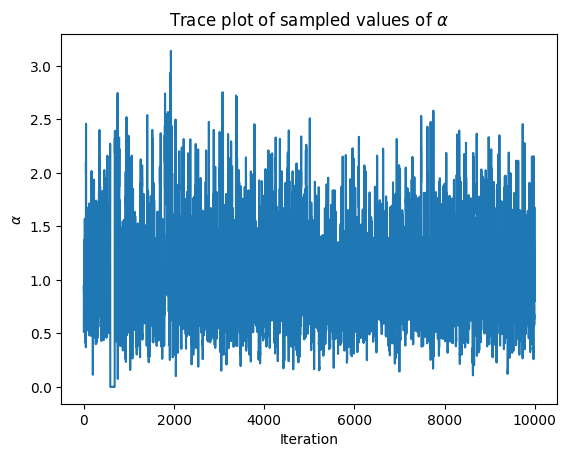

In [5]:
plot_samples(fit, 'alpha', r'$\alpha$')

The chain explores values of $\alpha$ between $0$ approximately $3$ and only appears to get stuck once.

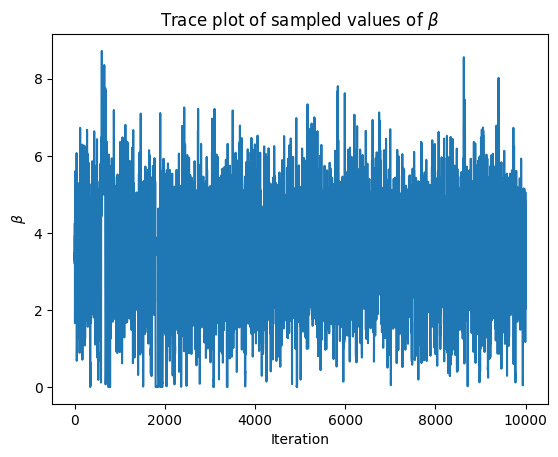

In [6]:
plot_samples(fit, 'beta', r'$\beta$')

The chain explores values of $\beta$ between $0$ approximately $9$ and does not appear to get stuck.

Assuming an additive absolute value loss function,

$$
\ell(\hat{\theta}, \theta) = |\hat{\alpha} - \alpha| + |\hat{\beta} - \beta|,
$$

the Bayesian posterior estimates $\hat{\alpha}$ and $\hat{\beta}$ will be the medians of the sampled values of $\alpha$ and $\beta$, respectively.

In [7]:
# Extract samples
samples_alpha = fit['alpha']
samples_beta = fit['beta']

# Calculate medians, then print
median_alpha = np.median(samples_alpha)
median_beta = np.median(samples_beta)
print(f'Posterior estimate: ({median_alpha}, {median_beta})')

Posterior estimate: (0.9791136631778685, 3.3370078586241148)


To check model fit, I will calculate a posterior predictive $p$-value using the negative log-likelihood function as the test statistic.

We must update the Stan code.

In [8]:
stan_code_updated = """
functions {
  real linear_hazard_lpdf(real t, real alpha, real beta) {
    return log(alpha + beta * t) - alpha * t - 0.5 * beta * t^2;
  }
  real linear_hazard_rng(real alpha, real beta) {
    return sqrt((alpha / beta)^2 + exponential_rng(beta / 2)) - alpha / beta;
  }
}

data {
  int<lower=0> n;              // number of observations
  array[n] real<lower=0> t;    // observed data
}

parameters {
  real<lower=0> alpha;
  real<lower=0> beta;
}

model {
  alpha ~ gamma(0.1, 0.1);
  beta ~ gamma(0.2, 0.1);
  for (i in 1:n) {
    t[i] ~ linear_hazard(alpha, beta);
  }
}

generated quantities {
  array[n] real<lower=0> t_rep;
  real log_lhd = 0;
  real log_lhd_rep = 0;
  real ppp;
  for (i in 1:n) {
    log_lhd += linear_hazard_lpdf(t[i] | alpha, beta);
    t_rep[i] = linear_hazard_rng(alpha, beta);
    log_lhd_rep += linear_hazard_lpdf(t_rep[i] | alpha, beta);
  }
  ppp = log_lhd >= log_lhd_rep ? 1 : 0;
}
"""

In [9]:
# Build Stan object for model, then sample
sm = stan.build(stan_code_updated, sm_data, random_seed=1)
fit = sm.sample(num_chains=chains, num_samples=samples, num_warmup=burn, save_warmup=False)

# Calculate posterior predictive p-value, then print
samples_ppp = fit['ppp']
mean_ppp = np.mean(samples_ppp)
print(f'Posterior predictive p-value: {mean_ppp}')

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_kyg8w93z/model_7muzjch6.stan', line 22, column 16: There
    is a gamma or inverse-gamma distribution with parameters that are equal
    to each other and set to values less than 1. This is mathematically
    acceptable and can make sense in some problems, but typically we see this
    model used as an attempt to assign a noninformative prior distribution.
    In fact, priors such as inverse-gamma(.001,.001) can be very strong, as
    explained by Gelman (2006). Instead we recommend something like a
    normal(0,1) or student_t(4,0,1), with parameter constrained to be
    positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!


Posterior predictive p-value: 0.4703


The $p$-value suggests no statistical significance, suggesting a good model fit.